In [5]:
import time
import numba
from numba import cuda
from numba.cuda.random import xoroshiro128p_uniform_float32, create_xoroshiro128p_states, xoroshiro128p_normal_float64
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# CUDA kernel to calculate fitness values
@cuda.jit
def cuda_get_fitnesses(population, points, fitnesses):
    index = cuda.grid(1)
    if index < population.shape[0]:
        fitness = 0
        for point in points:
            value = 0
            for j in range(population.shape[1] - 1):
                value += population[index, j] * point[0] ** j
            fitness += (point[1] - value) ** 2
        fitnesses[index] = fitness

# CUDA kernel to generate the next population
@cuda.jit
def cuda_get_next_population(rng_states, population, new_population):
    index = cuda.grid(1)
    current_size = population.shape[0]
    if index < current_size:
        i = int(xoroshiro128p_uniform_float32(rng_states, index) * current_size)
        j = int(xoroshiro128p_uniform_float32(rng_states, index) * current_size)
        while i == j:
            j = int(xoroshiro128p_uniform_float32(rng_states, index) * current_size)

        shift = int(xoroshiro128p_uniform_float32(rng_states, index) * gens_count) or 1
        for k in range(shift):
            new_population[index, k] = population[i, k]
            new_population[index + current_size, k] = population[j, k]
        for k in range(gens_count - shift):
            new_population[index, shift + k] = population[j, shift + k]
            new_population[index + current_size, shift + k] = population[i, shift + k]

        for k in range(gens_count):
            if xoroshiro128p_uniform_float32(rng_states, index) < 0.02:
                new_population[index, k] += E + D * xoroshiro128p_normal_float64(rng_states, index)
            if xoroshiro128p_uniform_float32(rng_states, index) < 0.02:
                new_population[index + current_size, k] += E + D * xoroshiro128p_normal_float64(rng_states, index)

# Generate data points based on coefficients
def get_points(coefficients, points_count):
    points = np.zeros((points_count, 2))
    for point in points:
        point[0] = -5 + np.random.rand() * 10
        point[1] = get_y(coefficients, point[0]) + np.random.rand()
    return points

# Calculate y-value based on coefficients
def get_y(coefficients, x):
    return sum(coef * x ** i for i, coef in enumerate(coefficients))

# Run CUDA kernel to calculate fitnesses
def run_cuda_get_fitnesses(population, points):
    d_points = cuda.to_device(points)
    d_population = cuda.to_device(population)
    d_fitnesses = cuda.device_array(population.shape[0])
    threads_per_block = 256
    blocks_per_grid = (population.shape[0] + threads_per_block - 1) // threads_per_block
    cuda_get_fitnesses[blocks_per_grid, threads_per_block](d_population, d_points, d_fitnesses)
    return d_fitnesses.copy_to_host()

# Run CUDA kernel to generate the next population
def run_cuda_get_next_population(population):
    d_population = cuda.to_device(population)
    d_new_population = cuda.device_array((population_size * 2, gens_count + 1))
    threads_per_block = 256
    blocks_per_grid = (population_size + threads_per_block - 1) // threads_per_block
    cuda_get_next_population[blocks_per_grid, threads_per_block](rng_states, d_population, d_new_population)
    return d_new_population.copy_to_host()

# Main parameters
points_count = 10 ** 3
iter_count = 10 ** 3
gens_count = 6
E = 0
D = 1
error = 0.1
population_size = 10 ** 3
coefficients = np.random.rand(gens_count)
coefficients[-1] += 1
points = get_points(coefficients, points_count)
rng_states = create_xoroshiro128p_states(256 * 1024, seed=1)
population = np.random.rand(population_size, gens_count + 1)

# Genetic algorithm loop
best_fitness = np.inf
best_solution = None
start_time = time.time()

for current_iter in range(iter_count):
    fitnesses = run_cuda_get_fitnesses(population, points)
    population[:, -1] = fitnesses
    population = population[np.argsort(population[:, -1])]

    if population[0, -1] < best_fitness:
        best_fitness = population[0, -1]
        best_solution = population[0, :-1]
        if best_fitness < error:
            break

    population = run_cuda_get_next_population(population[:population_size // 2])

print(f"Execution time: {time.time() - start_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Execution time: 6.59 seconds


True coefficients: [0.56237353 0.8225707  0.46726579 0.55313258 0.63416845 1.64345964]
Found coefficients: [ 2.34432084 -0.06163891 -0.02719066  0.72787791  0.65705881  1.63703767]
Iterations: 999


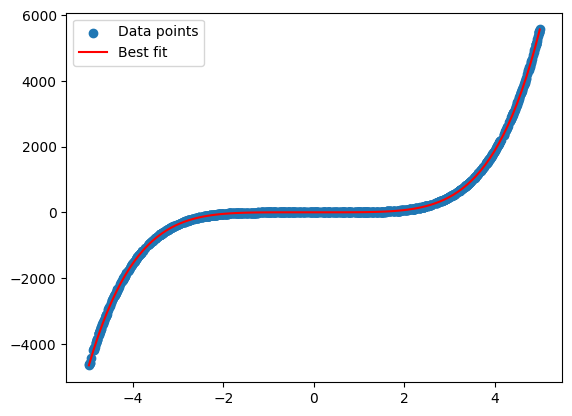

In [9]:
# Visualize results
n = 100
x_lin = np.linspace(points[:, 0].min(), points[:, 0].max(), n)
y_pred = np.array([get_y(best_solution, x) for x in x_lin])

print(f"True coefficients: {coefficients}")
print(f"Found coefficients: {best_solution}")
print(f"Iterations: {current_iter}")

plt.scatter(points[:, 0], points[:, 1], label="Data points")
plt.plot(x_lin, y_pred, color="red", label="Best fit")
plt.legend()
plt.savefig("result.png")
plt.show()
